In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
from scipy.interpolate import approximate_taylor_polynomial

from qucat import Network,GUI,L,J,C,R
import qucat

from lib import Convert

In [3]:
from ipywidgets import IntProgress         # This is a progress bar, it is optional.
from IPython.display import display
import time

Проверим конвертацию разных величин друг в друга

Джозефсоновская энергия

In [4]:
print(f"""For   L_J = 60 pH, the Josephson junction energy is
      E_J = {Convert.Ej_from_Lj(60, 'pH', 'GHz'):.1f} GHz and 
      I_c = {Convert.Ic_from_Lj(60, 'pH', 'uA'):.1f} uA""")

For   L_J = 60 pH, the Josephson junction energy is
      E_J = 2724.4 GHz and 
      I_c = 5.5 uA


In [5]:
print(f"""For   I_C = 7.1 uA, the Josephson junction energy is
      E_J = {Convert.Ej_from_Ic(7.1, 'uA', 'GHz'):.1f} GHz and 
      L_c = {Convert.Lj_from_Ic(7.1, 'uA', 'pH'):.1f} pH""")

For   I_C = 7.1 uA, the Josephson junction energy is
      E_J = 3526.5 GHz and 
      L_c = 46.4 pH


In [6]:
round(Convert.Ej_from_Ic(Convert.Ic_from_Lj(Convert.Ej_from_Lj(60, 'pH', 'GHz'), 'pH', 'uA'), 'uA', 'GHz'),2)

60.0

Зарядовая энергия

In [7]:
print(f"""For C_s = 1.0 fF the Charging energy is
    E_c = {Convert.Ec_from_Cs(1,'fF', 'GHz'):.1f} GHz""")

For C_s = 1.0 fF the Charging energy is
    E_c = 19.4 GHz


In [8]:
round(Convert.Ec_from_Cs(Convert.Cs_from_Ec(60, 'GHz', 'fF'), 'fF', 'GHz'),2)

60.0

Потенциальная энергия одной Улитки

In [13]:
def SNAIL_U_simple(phi):
    return -alpha * np.cos(phi) - 3 * np.cos((phi_ext * 2 * np.pi - phi)/3)

In [9]:
def SNAIL_U(phi, alpha, phi_ext):
    #return -alpha * E_J * np.cos(phi) - 3 * E_J * np.cos((phi_ext - phi)/3)
    return -alpha * np.cos(phi) - 3 * np.cos((phi_ext * 2 * np.pi - phi)/3)

In [10]:
phi_ext = 0.41
alpha = 0.29
E_J = 60e-12 

phases = np.linspace(-3*np.pi, 3*np.pi, 2001)       
energies = SNAIL_U(phases, alpha, phi_ext)

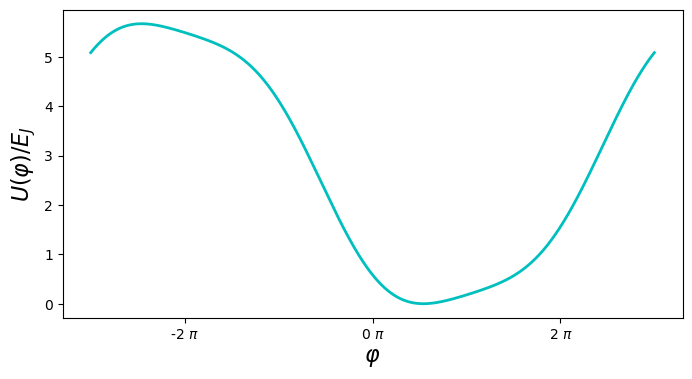

In [11]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 4))

p = axes.plot(phases/np.pi, energies-min(energies), 'c', linewidth=2.0)

axes.set_xlabel(r'$\varphi$', fontsize=16, **hfont)
axes.set_ylabel(r'$U(\varphi)/E_J$', fontsize=16, **hfont)
axes.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
axes.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base = 2.0))

Разложим эту функцию в ряд Тейлора вблизи минимального значения $\varphi_{min}$

In [14]:
phi_min = phases[np.argmin(energies)]
expansion = approximate_taylor_polynomial(SNAIL_U_simple, phi_min, 8, 0.01, order = 8 + 1)
print('phi_min =', phi_min, ', c0 =',expansion[0])
print('c1 =',expansion[1], ', c2 =',expansion[2])
print('c3 =',expansion[3], ', c4 =',expansion[4])
print('c5 =',expansion[5], ', c6 =',expansion[6])
print('c7 =',expansion[7], ', c8 =',expansion[8])

phi_min = 1.6964600329384876 , c0 = -2.8356118548625533
c1 = -0.001318533563105924 , c2 = 0.14137993075801294
c3 = -0.042599797878160296 , c4 = 3.500113951364909e-05
c5 = 0.0034147456118168904 , c6 = 0.03523995247675263
c7 = -14.347929334700359 , c8 = -184.21409280148214


Также визуализируем коэффициенты разложения в ряд Тейлора потенциала, в особенности 3-ю и 4-ю степень, в зависимости от $\alpha$ и $\varphi_{ext}$

We operate in a regime where phase ﬂuctuations are suppressed, and the potential can be Taylor expanded near one of its equivalent minima.

$U_{eff}(\hat\varphi)/E_J = c_2\hat\varphi^2 + c_3\hat\varphi^3 + c_4\hat\varphi^4 + \dots$, where $\hat\varphi = \varphi - \varphi_{min}$

In [15]:
phase_steps = 501
alpha_steps = 501

Phases_ext = np.linspace(0, 0.49, phase_steps)  # Ф_ext/Ф_0      
Alphas = np.linspace(0, 1, alpha_steps) 
phases = np.linspace(-3*np.pi, 3*np.pi, 1001)  

In [16]:
c1 = np.zeros((phase_steps,alpha_steps), dtype=float)
c2 = np.zeros((phase_steps,alpha_steps), dtype=float)
c3 = np.zeros((phase_steps,alpha_steps), dtype=float)
c4 = np.zeros((phase_steps,alpha_steps), dtype=float)

f = IntProgress(min=0, max=phase_steps) # instantiate the bar
display(f) # display the bar


for phase_ext_id, phase_ext_value, in enumerate(Phases_ext):
    for alpha_id, alpha_value, in enumerate(Alphas):
        alpha = alpha_value
        phi_ext = phase_ext_value
        energies = SNAIL_U(phases, alpha_value, phase_ext_value)
        phi_min = phases[np.argmin(energies)]
        expansion = approximate_taylor_polynomial(SNAIL_U_simple, phi_min, 4, 0.01, order = 4 + 1)
        c1[phase_ext_id][alpha_id] = expansion[1]
        c2[phase_ext_id][alpha_id] = expansion[2]
        c3[phase_ext_id][alpha_id] = expansion[3]
        c4[phase_ext_id][alpha_id] = expansion[4]
        
    f.value += 1

IntProgress(value=0, max=501)

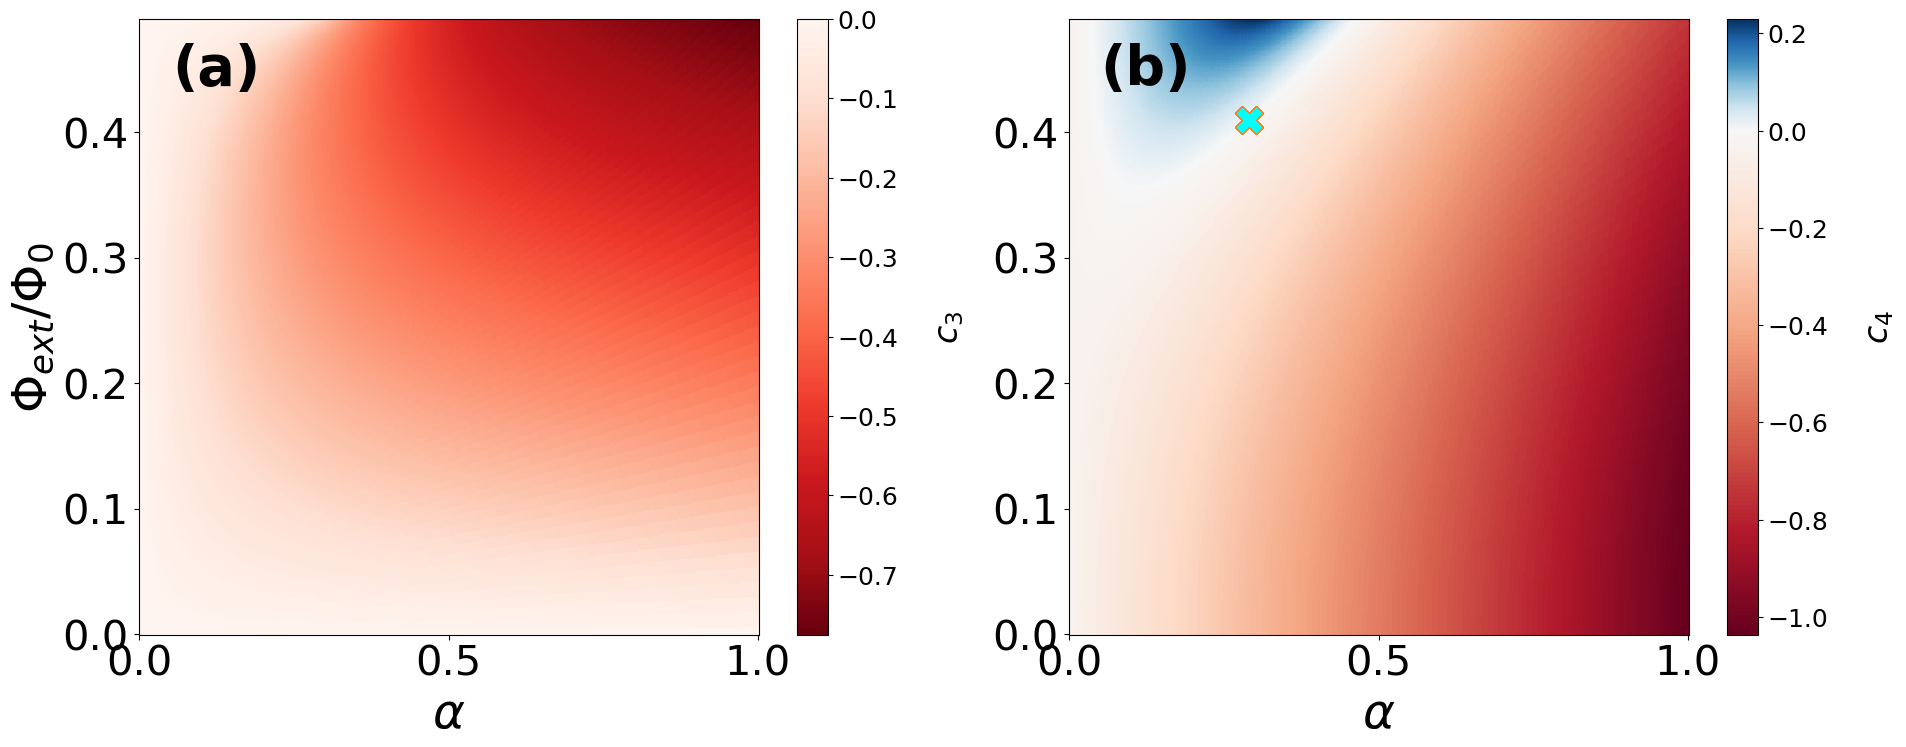

In [35]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,2,figsize=(22, 8))

#plt.rcParams["text.usetex"] = True

p = axes[0].pcolor(Alphas, Phases_ext, c3, cmap = cm.Reds_r, shading='nearest')

axes[0].axis('tight')
axes[0].set_xlabel(r'$\alpha$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$\Phi_{ext}/\Phi_0$', fontsize=35, **hfont, rotation=90)

axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)

cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$c_3$', labelpad=25, rotation=90, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18) 

plt.plot(0.29, 0.41, 'X', markerfacecolor = 'cyan', markersize=20)                 # Additional point

#---------------------------------------------------------------------------

norm = TwoSlopeNorm(vmin=c4.min(), vcenter=0, vmax=c4.max())
p = axes[1].pcolor(Alphas, Phases_ext, c4, norm=norm, cmap = cm.RdBu, shading='nearest')

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)

#axes[1].set_yticklabels([])
axes[1].set_xlabel(r'$\alpha$', fontsize=35, **hfont)

cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'$c_4$', labelpad=25, rotation=90, fontsize=24, **hfont)
cb.ax.set_yscale('linear')
cb.ax.tick_params(labelsize=18)

#axes[0].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)
#axes[1].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)

matplotlib.pyplot.text(-1.45, 0.45, '(a)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text(0.05, 0.45, '(b)', fontsize=40, weight="black",  verticalalignment='center')

plt.plot(0.29, 0.41, 'X', markerfacecolor = 'cyan', markersize=20)                 # Additional point

#plt.gcf().set_size_inches(33,8)
#plt.savefig("C:/Users/kiril/Desktop/Fig1.png", bbox_inches="tight")

Попробую аналитическое решение

In [30]:
def c3_coeff(phi, alpha, phi_ext):
    return -alpha * np.sin(phi) - 1/9 * np.sin((phi_ext * 2 * np.pi - phi)/3)
def c4_coeff(phi, alpha, phi_ext):
    return -alpha * np.cos(phi) - 1/27 * np.cos((phi_ext * 2 * np.pi - phi)/3)
def c5_coeff(phi, alpha, phi_ext):
    return alpha * np.sin(phi) - 1/81 * np.sin((phi_ext * 2 * np.pi - phi)/3)

In [31]:
phase_steps = 501
alpha_steps = 501

Phases_ext = np.linspace(0, 0.49, phase_steps)        
Alphas = np.linspace(0, 1, alpha_steps) 
phases = np.linspace(-3*np.pi, 3*np.pi, 1001)  

c3 = np.zeros((phase_steps,alpha_steps), dtype=float)
c4 = np.zeros((phase_steps,alpha_steps), dtype=float)
c5 = np.zeros((phase_steps,alpha_steps), dtype=float)

f = IntProgress(min=0, max=phase_steps) # instantiate the bar
display(f) # display the bar

for phase_ext_id, phase_ext_value, in enumerate(Phases_ext):
    for alpha_id, alpha_value, in enumerate(Alphas):
        alpha = alpha_value
        phi_ext = phase_ext_value
        energies = SNAIL_U(phases, alpha_value, phase_ext_value)
        phi_min = phases[np.argmin(energies)]
        c3[phase_ext_id][alpha_id] = c3_coeff(phi_min, alpha_value, phase_ext_value)
        c4[phase_ext_id][alpha_id] = c4_coeff(phi_min, alpha_value, phase_ext_value)
        c5[phase_ext_id][alpha_id] = c5_coeff(phi_min, alpha_value, phase_ext_value)
    f.value +=1

IntProgress(value=0, max=501)

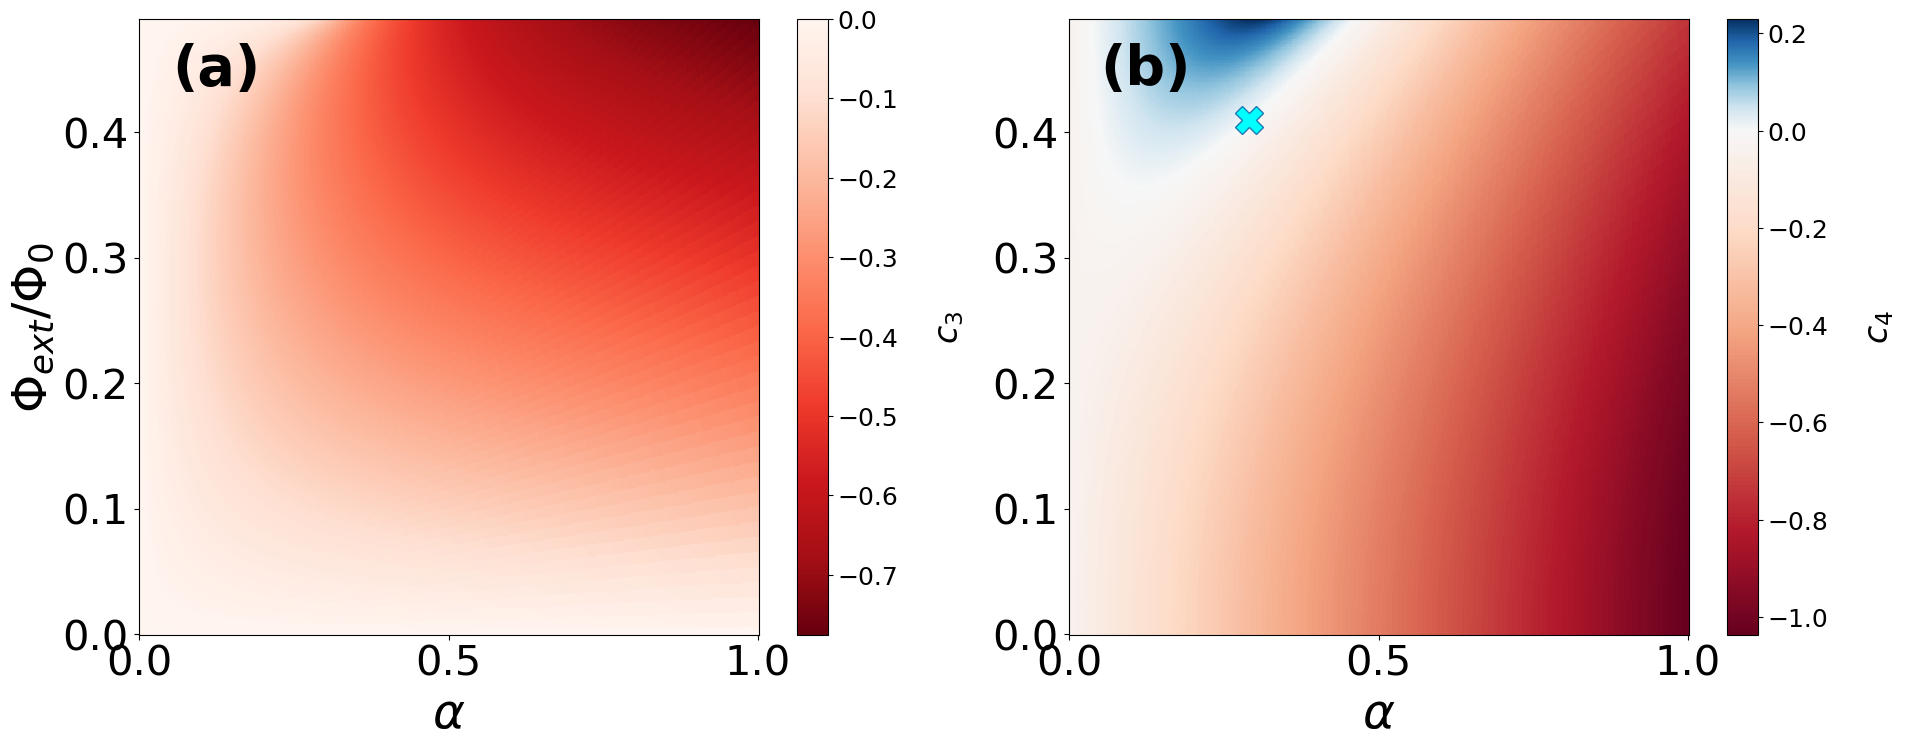

In [34]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,2,figsize=(22, 8))

#plt.rcParams["text.usetex"] = True

p = axes[0].pcolor(Alphas, Phases_ext, c3, cmap = cm.Reds_r, shading='nearest')

axes[0].axis('tight')
axes[0].set_xlabel(r'$\alpha$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$\Phi_{ext}/\Phi_0$', fontsize=35, **hfont, rotation=90)

axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)

cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$c_3$', labelpad=25, rotation=90, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18) 

#---------------------------------------------------------------------------

norm = TwoSlopeNorm(vmin=c4.min(), vcenter=0, vmax=c4.max())
p = axes[1].pcolor(Alphas, Phases_ext, c4, norm=norm, cmap = cm.RdBu, shading='nearest')

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)
#axes[1].set_yticklabels([])

axes[1].set_xlabel(r'$\alpha$', fontsize=35, **hfont)

cb = fig.colorbar(p, ax=axes[1])
cb.ax.set_yscale('linear')
cb.set_label(r'$c_4$', labelpad=25, rotation=90, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

#axes[0].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)
#axes[1].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)

matplotlib.pyplot.text(-1.45, 0.45, '(a)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text(0.05, 0.45, '(b)', fontsize=40, weight="black",  verticalalignment='center')

plt.plot(0.29, 0.41, 'X', markerfacecolor = 'cyan', markersize=20)                 # Additional point

plt.gcf().set_size_inches(22,8)
plt.savefig("C:/Users/kiril/OneDrive/Desktop/Fig1.png", bbox_inches="tight")